In [13]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import optuna
from functools import partial

# Model
Simple hybrid model with reaploading in a circuit. Circuit is implemented using tensorcircuit.

In [14]:
from flax import linen as nn
from flax import struct
import jax
import jax.numpy as jnp
import tensorcircuit as tc
tc.set_backend("jax")

# ===============================================================
# Quantum Circuit Function
# ===============================================================
def quantum_circuit(x, weights, entanglement_weights, final_rotations, num_qubits, layer_depth, num_frequencies):
    """
    Build a quantum circuit using tensorcircuit, with parameterized RXX entanglement and final rotations.

    Args:
      x: JAX array of shape (num_qubits,) representing the input.
      weights: Array of shape (num_frequencies, layer_depth, num_qubits, 3) for single-qubit rotations.
      entanglement_weights: Array of shape (num_frequencies, layer_depth, num_qubits-1) for RXX angles.
      final_rotations: Array of shape (num_qubits, 3) for the final variational rotation layer.
      num_qubits: Number of qubits.
      layer_depth: Number of variational layers per reuploading block.
      num_frequencies: Number of reuploading blocks.

    Returns:
      JAX array of shape (num_qubits,) with the expectation values of PauliZ.
    """
    import tensorcircuit as tc  # assuming tensorcircuit is available
    c = tc.Circuit(num_qubits)
    for f in range(num_frequencies):
        # Input encoding
        for j in range(num_qubits):
            c.rx(j, theta=x[j])
        # Variational layers
        for k in range(layer_depth):
            for j in range(num_qubits):
                theta, phi, alpha = weights[f, k, j]
                c.r(j, theta=theta, phi=phi, alpha=alpha)
            for j in range(num_qubits - 1):
                theta_ent = entanglement_weights[f, k, j]
                c.rxx(j, j + 1, theta=theta_ent)
    # Final rotation layer
    for j in range(num_qubits):
        theta, phi, alpha = final_rotations[j]
        c.r(j, theta=theta, phi=phi, alpha=alpha)
    out = [c.expectation_ps(z=[j]) for j in range(num_qubits)]
    return jnp.real(jnp.array(out))

# ===============================================================
# Quantum Neural Network (QNN) with tensorcircuit
# ===============================================================
class QNN(nn.Module):
    num_features: int = 8         # classical input; num_qubits computed automatically
    num_frequencies: int = 1      
    layer_depth: int = 1          
    num_output: int = 1
    init_std_C: float = 1       # used in final dense layer
    init_std_Q: float = 1       # used for quantum circuit weights
    init_std_F: float = 1.0  
    trainable_frequency: bool = True

    @property
    def num_qubits(self):
        # In this design, we assume one qubit per classical feature.
        return self.num_features

    @nn.compact
    def __call__(self, x):
        # x: shape (batch_size, num_qubits)
        num_qubits = self.num_qubits
        # Frequency scaling.
        frequency = (
            self.param("frequency", lambda rng: jnp.array(self.init_std_F, dtype=x.dtype))
            if self.trainable_frequency else self.init_std_F
        )
        x_scaled = x * frequency

        # Define shapes for the combined weights.
        shape_weights = (self.num_frequencies, self.layer_depth, num_qubits, 3)
        shape_entanglement = (self.num_frequencies, self.layer_depth, num_qubits - 1)
        shape_final = (num_qubits, 3)

        # Compute total sizes as Python integers.
        size_weights = int(np.prod(shape_weights))
        size_entanglement = int(np.prod(shape_entanglement))
        size_final = int(np.prod(shape_final))
        total_size = size_weights + size_entanglement + size_final

        # Combined parameter for all quantum circuit weights.
        quanum_weights = self.param(
            "quanum_weights",
            lambda rng, shape: jax.random.normal(rng, shape) * self.init_std_Q,
            (total_size,)
        )

        # Slice and reshape to recover individual parameters.
        weights = jnp.reshape(quanum_weights[:size_weights], shape_weights)
        entanglement_weights = jnp.reshape(
            quanum_weights[size_weights:size_weights + size_entanglement], shape_entanglement
        )
        final_rotations = jnp.reshape(
            quanum_weights[size_weights + size_entanglement:], shape_final
        )

        # Build the quantum circuit output (vectorized over the batch).
        circuit_out = jax.vmap(
            lambda single_x: quantum_circuit(
                single_x,
                weights,
                entanglement_weights,
                final_rotations,
                num_qubits,
                self.layer_depth,
                self.num_frequencies
            )
        )(x_scaled)
        # Use a dense layer on the circuit output.
        output = nn.Dense(self.num_output,
                          kernel_init=nn.initializers.normal(stddev=self.init_std_C)
                         )(circuit_out)
        return output

2025-04-24 10:28:23.055678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745483303.074896 1114221 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745483303.080614 1114221 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module


# Plotting function

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metriс_hystories(metrics_history_list, labels=None, x_scale="log", y_scale="log", title=None):
    """
    Plot aggregated metric histories (mean ± std) over multiple runs.

    Args:
      metrics_history_list (list of list of dict): Each element is a metrics_history
          from one call to train_multiple_cls_models_vmap_lion_dynamic,
          i.e. a list of replica dicts with keys
          'train_loss','train_accuracy','val_loss','val_accuracy','smoothed_val_loss'.
      labels (list of str, optional): Legend labels for each run.
      x_scale (str): 'linear' or 'log' for x-axis.
      y_scale (str): 'linear' or 'log' for y-axis.
      title (str, optional): Overall figure title.

    Returns:
      fig, axs: Matplotlib Figure and 2×2 Axes array.
    """
    if not metrics_history_list:
        raise ValueError("metrics_history_list is empty.")
    n_runs = len(metrics_history_list)
    if labels is None:
        labels = [f"Run {i+1}" for i in range(n_runs)]
    if len(labels) != n_runs:
        raise ValueError("Number of labels must match number of runs.")

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    for mh, label in zip(metrics_history_list, labels):
        # mh: list of N replica histories, each a dict of lists
        train_losses = np.array([rep["train_loss"]          for rep in mh])
        train_accs   = np.array([rep["train_accuracy"]     for rep in mh])
        smooth_vals  = np.array([rep["smoothed_val_loss"]  for rep in mh])
        val_accs     = np.array([rep["val_accuracy"]       for rep in mh])

        epochs = np.arange(train_losses.shape[1])

        # Training Loss
        tmean = train_losses.mean(axis=0)
        tstd  = train_losses.std(axis=0)
        axs[0, 0].plot(epochs, tmean, label=label)
        axs[0, 0].fill_between(epochs, tmean - tstd, tmean + tstd, alpha=0.2)

        # Validation Loss (Smoothed)
        vmean = smooth_vals.mean(axis=0)
        vstd  = smooth_vals.std(axis=0)
        axs[0, 1].plot(epochs, vmean, label=label)
        axs[0, 1].fill_between(epochs, vmean - vstd, vmean + vstd, alpha=0.2)

        # Training Error = 1 - accuracy
        terr_mean = 1.0 - train_accs.mean(axis=0)
        terr_std  = train_accs.std(axis=0)
        axs[1, 0].plot(epochs, terr_mean, label=label)
        axs[1, 0].fill_between(epochs,
                               terr_mean - terr_std,
                               terr_mean + terr_std,
                               alpha=0.2)

        # Validation Error = 1 - accuracy
        verr_mean = 1.0 - val_accs.mean(axis=0)
        verr_std  = val_accs.std(axis=0)
        axs[1, 1].plot(epochs, verr_mean, label=label)
        axs[1, 1].fill_between(epochs,
                               verr_mean - verr_std,
                               verr_mean + verr_std,
                               alpha=0.2)

    # Axis formatting
    for ax in axs.flat:
        ax.set_xlabel("Epoch")
        ax.set_xscale(x_scale)
        ax.set_yscale(y_scale)
        ax.grid(True, which="both", ls="--")
        ax.legend()

    axs[0, 0].set_ylabel("Loss")
    axs[1, 0].set_ylabel("Error (1 - Accuracy)")
    axs[0, 0].set_title("Training Loss")
    axs[0, 1].set_title("Validation Loss (Smoothed)")
    axs[1, 0].set_title("Training Error")
    axs[1, 1].set_title("Validation Error")

    if title:
        fig.suptitle(title, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
    else:
        plt.tight_layout()

    return fig, axs

# Training

In [16]:
# Load semeion numbers dataset with PCA num_features
from pca_datasets import generate_dataset_semeion_pca
num_features = 4
X_train, y_train, X_val, y_val, X_test, y_test = generate_dataset_semeion_pca(
    n_components=num_features,
    test_size=0.15,
    val_size=0.15,
    random_state=0,
)

In [17]:
num_frequencies = 1
model = QNN(
    num_features = num_features,
    num_frequencies = num_frequencies,
    layer_depth = 2,
    num_output = 10)

In [9]:
# Number of parameters in the 
from training_jax import count_parameters, create_train_state_cls
rng = jax.random.PRNGKey(1)
x_sample = jnp.array(np.ones([1,num_features]))  # one sample for initialization
state = create_train_state_cls(model, rng, 1, 1, x_sample)
count_parameters(state.params)

93

In [13]:
from train_multiple_jax_models import train_multiple_cls_models_vmap_lion_dynamic

# Dictionary with std for initialising weights with names corresponding to the keys. 
# Not specified weights are initialised with "default" std
init_std_dict = {
    "default": 1e-1,
    "frequency": 1,
    "quanum_weights": 1e-1
}

# Dictionary with learning rates for weights with names corresponding to the keys. 
# Not specified weights are trained with "default" lr
lr_dict = {
    "default": 1e-2,
    "frequency": 1e-2,
    "quanum_weights": 1e-2
}

#  We sweep throgh weight_decay
weight_decay_list = [1e-3,1e-2,1e-1]

history_list = []
test_metrics_list = []
for weight_decay in weight_decay_list:
    final_state, history, test_metrics = train_multiple_cls_models_vmap_lion_dynamic(
        N=10, # Number of models trained simultaniously with different initialisiation seeds
        model=model,
        X_train=X_train, y_train=y_train,
        X_val=  X_val,   y_val=y_val,
        X_test= X_test,  y_test=y_test,
        batch_size=200,
        target_epochs=10000,
        patience=100,
        init_std_dict=init_std_dict,
        lr_dict=lr_dict,
        initial_wd=weight_decay,
        print_output=True,
        ema_decay=0.3,
        seed=np.random.randint(0,1e16),
    )
    history_list += [history]
    test_metrics_list += [test_metrics]

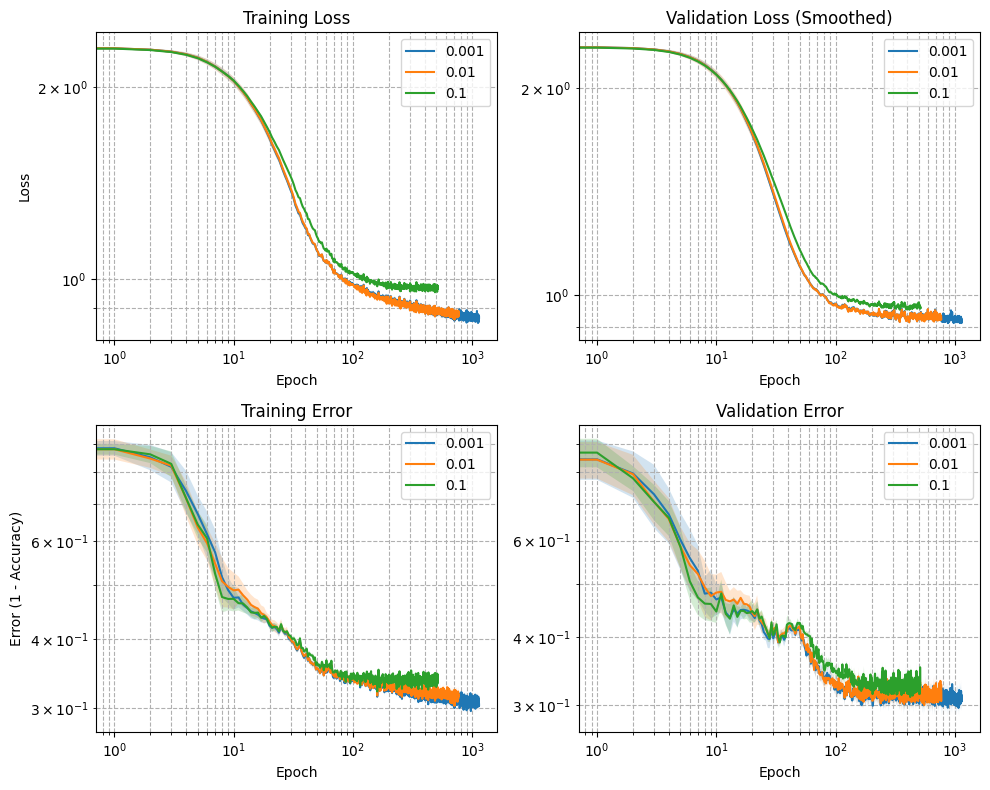

In [11]:
plot_metric_hystories(history_list,labels = weight_decay_list);

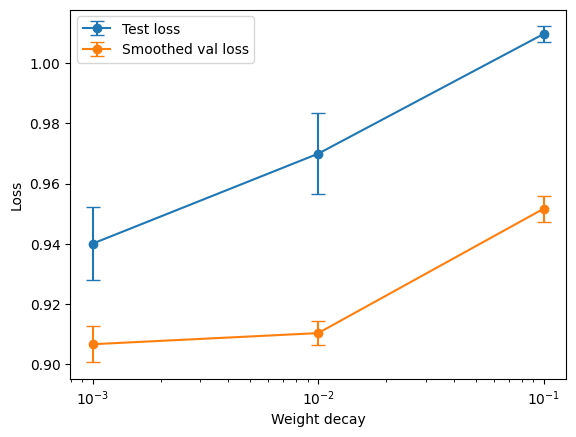

In [14]:
test_loss_mean = [np.mean(test_metrics["test_loss"]) for test_metrics in test_metrics_list]
test_loss_std = [np.std(test_metrics["test_loss"]) for test_metrics in test_metrics_list]


val_loss_mean = [
    np.mean([min(metrics["smoothed_val_loss"]) for metrics in history]) 
    for history in history_list]
val_loss_std = [
    np.std([min(metrics["smoothed_val_loss"]) for metrics in history]) 
    for history in history_list]

ax = plt.subplot()
ax.errorbar(weight_decay_list,test_loss_mean,test_loss_std, marker = "o", capsize = 5, label = "Test loss")
ax.errorbar(weight_decay_list,val_loss_mean,val_loss_std, marker = "o", capsize = 5, label = "Smoothed val loss")

ax.set_xscale("log")
ax.set_xlabel("Weight decay")
ax.set_ylabel("Loss")
ax.legend()

# HPO

In [15]:
def objective(trial, model, batch_size=None):
    # Suggest hyperparameters
    base_wd    = trial.suggest_float("weight_decay",           1e-3, 1e+0, log=True)

    if batch_size is None:
        batch_size = trial.suggest_int("batch_size", 10,1000)

    # Build the init_std_dict exactly like we do for lr_dict
    init_std_dict = {
        "default": trial.suggest_float("default_std",               1e-1, 1e+1, log=True),
        "frequency": trial.suggest_float("frequency_std",           1e-1, 1e+1, log=True),
        "quanum_weights": trial.suggest_float("quanum_weights_std", 1e-1, 1e+1, log=True)
    }

    # lr_dict must include a "default" entry
    lr_dict = {
        "default": trial.suggest_float("default_lr",               1e-3, 1e-1, log=True),
        "frequency": trial.suggest_float("frequency_lr",           1e-3, 1e-1, log=True),
        "quanum_weights": trial.suggest_float("quanum_weights_lr", 1e-3, 1e-1, log=True)
    }

    final_state, metrics_history, test_metrics = train_multiple_cls_models_vmap_lion_dynamic(
        N=1,
        model=model,
        X_train=X_train, y_train=y_train,
        X_val=  X_val,   y_val=y_val,
        X_test= X_test,  y_test=y_test,
        batch_size=batch_size,
        target_epochs=10000,
        patience=100,
        init_std_dict=init_std_dict,
        lr_dict=lr_dict,
        initial_wd=base_wd,
        print_output=False,
        ema_decay=0.3,
        seed=np.random.randint(0,1e16),
    )

    # Convert the full trajectories to numpy arrays.
    # Each metrics_history entry is a dict with keys: "train_loss", "train_accuracy", "val_loss", "val_accuracy"
    # and each value is a list of epoch values.
    all_train_losses = np.array([hist["train_loss"] for hist in metrics_history])  # shape (N, epochs)
    all_train_accs   = np.array([hist["train_accuracy"] for hist in metrics_history])
    all_val_losses   = np.array([hist["val_loss"] for hist in metrics_history])
    all_val_accs     = np.array([hist["val_accuracy"] for hist in metrics_history])

    # Compute epoch-wise means (across the N models).
    mean_train_loss_per_epoch = np.mean(all_train_losses, axis=0)  # shape (epochs,)
    mean_train_acc_per_epoch   = np.mean(all_train_accs, axis=0)
    mean_val_loss_per_epoch   = np.mean(all_val_losses, axis=0)
    mean_val_acc_per_epoch     = np.mean(all_val_accs, axis=0)

    # Compute epoch-wise std (optional).
    std_train_loss_per_epoch = np.std(all_train_losses, axis=0)
    std_train_acc_per_epoch   = np.std(all_train_accs, axis=0)
    std_val_loss_per_epoch   = np.std(all_val_losses, axis=0)
    std_val_acc_per_epoch     = np.std(all_val_accs, axis=0)

    # Store full trajectories and summary statistics as trial user attributes.
#     trial.set_user_attr("mean_train_loss_trajectory", mean_train_loss_per_epoch.tolist())
#     trial.set_user_attr("std_train_loss_trajectory", std_train_loss_per_epoch.tolist())
#     trial.set_user_attr("mean_train_acc_trajectory", mean_train_acc_per_epoch.tolist())
#     trial.set_user_attr("std_train_acc_trajectory", std_train_acc_per_epoch.tolist())
#     trial.set_user_attr("mean_val_loss_trajectory", mean_val_loss_per_epoch.tolist())
#     trial.set_user_attr("std_val_loss_trajectory", std_val_loss_per_epoch.tolist())
#     trial.set_user_attr("mean_val_acc_trajectory", mean_val_acc_per_epoch.tolist())
#     trial.set_user_attr("std_val_acc_trajectory", std_val_acc_per_epoch.tolist())
    
#     # Optionally, store the complete test metrics as a user attribute in the trial.
#     trial.set_user_attr("test_loss", test_metrics['test_loss'])
#     trial.set_user_attr("test_accuracy", test_metrics['test_accuracy'])
    
    
    min_smoothed_val_loss = [min(hist["smoothed_val_loss"]) for hist in metrics_history]
    trial.set_user_attr("min_smoothed_val_loss", min_smoothed_val_loss)
    
    # Use the minimum smoothed validation loss as the objective
    mean_min_smoothed_val_loss = np.mean(min_smoothed_val_loss)
    
    print("mean_min_smoothed_val_loss %.3f" % mean_min_smoothed_val_loss)
    print("mean_test_loss %.3f"%np.mean(test_metrics['test_loss']))
    print("mean_test_accuracy %.3f"%np.mean(test_metrics['test_accuracy']))
    print("")
    
    # Return the mean test loss as the objective value.
    return mean_min_smoothed_val_loss

In [18]:
# === Create or Load the Optuna Study ===
study_name = f"fnn_num_features={num_features}_num_frequencies={num_frequencies}"
storage = "sqlite:///fnn_hpo_study.db"

study = optuna.create_study(
    study_name=study_name,
    storage=storage,
    load_if_exists=True,
    direction="minimize",  # Minimizing validation loss.
    sampler=optuna.samplers.TPESampler(),
)

# === Run the Optimization ===
study.optimize( partial(objective, model = model, batch_size = 200), n_trials=50 )

[I 2025-04-24 10:28:38,771] Using an existing study with name 'fnn_num_features=4_num_frequencies=1' instead of creating a new one.


# HPO results

In [7]:
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_contour,
    plot_slice
)

num_features = 4
num_frequencies = 1

study_name = f"fnn_num_features={num_features}_num_frequencies={num_frequencies}"
storage = "sqlite:///fnn_hpo_study.db"

# Load or reuse your study
study = optuna.load_study(study_name=study_name, storage=storage)

# 1. Optimization History
plot_optimization_history(study)

In [8]:
# 2. Parameter Importances (uses TreeSHAP-style approximation)
plot_param_importances(study)

In [10]:
# 3. Parallel Coordinates Plot (interactions of parameters vs. objective)
plot_parallel_coordinate(study)

In [11]:
# 4. Contour Plot (2D slices of objective surface)
plot_contour(study)

In [12]:
# 5. Slice Plot (objective vs. each hyperparameter)
plot_slice(study)

## Test the optimal parameters

In [19]:
params_to_test = [study.trials[0].params, study.best_params]

In [ ]:
from train_multiple_jax_models import train_multiple_cls_models_vmap_lion_dynamic


history_list = []
test_metrics_list = []
for params in params_to_test:
    
    # Suggest hyperparameters
    base_wd    = params["weight_decay"]

    batch_size = 200

    # Build the init_std_dict exactly like we do for lr_dict
    init_std_dict = {
        "default": params["default_std"],
        "frequency": params["frequency_std"],
        "quanum_weights": params["quanum_weights_std"]
    }

    # lr_dict must include a "default" entry
    lr_dict = {
        "default": params["default_lr"],
        "frequency": params["frequency_lr"],
        "quanum_weights": params["quanum_weights_lr"]
    }

    final_state, history, test_metrics = train_multiple_cls_models_vmap_lion_dynamic(
        N=10, # Number of models trained simultaniously with different initialisiation seeds
        model=model,
        X_train=X_train, y_train=y_train,
        X_val=  X_val,   y_val=y_val,
        X_test= X_test,  y_test=y_test,
        batch_size=200,
        target_epochs=10000,
        patience=100,
        init_std_dict=init_std_dict,
        lr_dict=lr_dict,
        initial_wd=base_wd,
        print_output=True,
        ema_decay=0.3,
        seed=np.random.randint(0,1e16),
    )
    history_list += [history]
    test_metrics_list += [test_metrics]

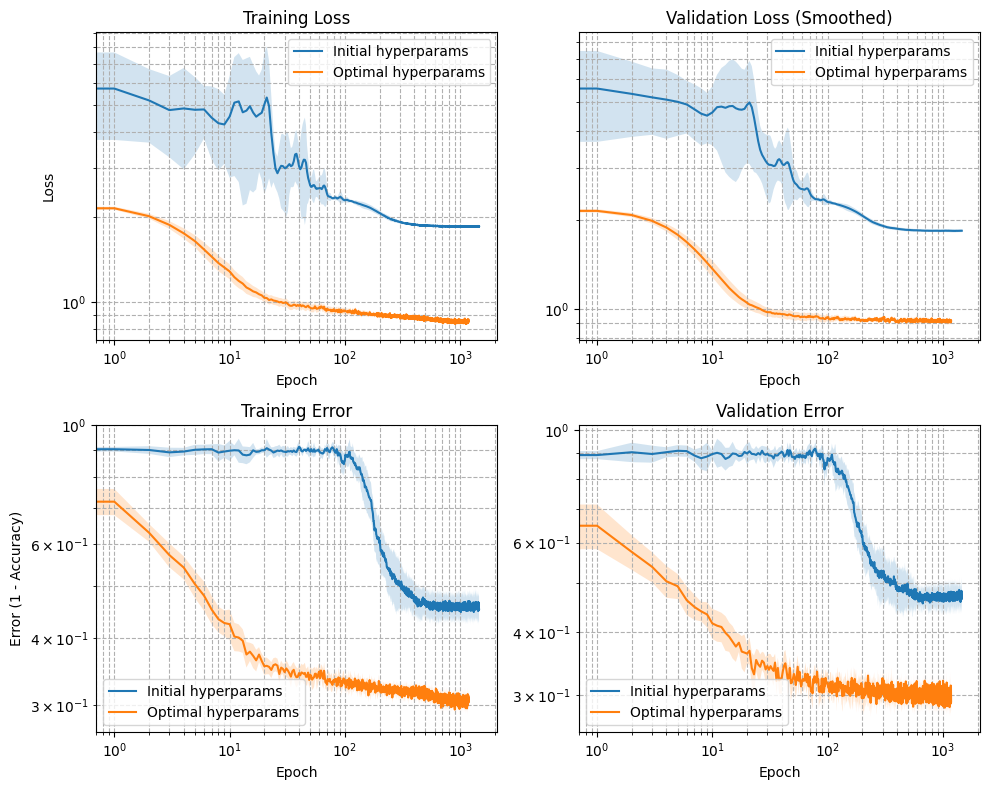

In [33]:
plot_metriс_hystories(history_list,labels = ["Initial hyperparams", "Optimal hyperparams"]);

In [34]:
test_loss_mean = [np.mean(test_metrics["test_loss"]) for test_metrics in test_metrics_list]
test_loss_std = [np.std(test_metrics["test_loss"]) for test_metrics in test_metrics_list]


val_loss_mean = [
    np.mean([min(metrics["smoothed_val_loss"]) for metrics in history]) 
    for history in history_list]
val_loss_std = [
    np.std([min(metrics["smoothed_val_loss"]) for metrics in history]) 
    for history in history_list]

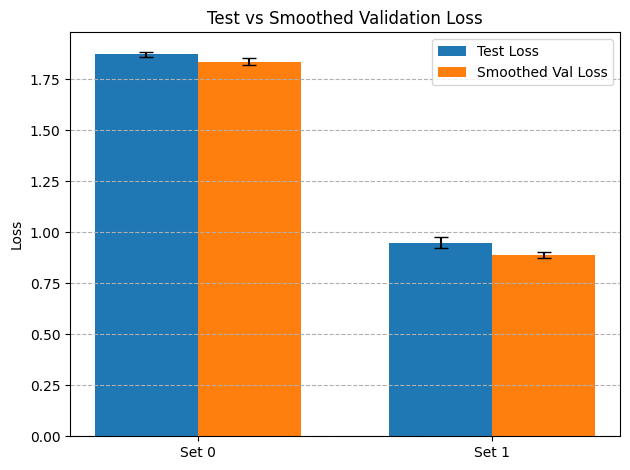

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your own):
# test_loss_mean, test_loss_std, val_loss_mean, val_loss_std are already defined

labels = ["Set 0", "Set 1"]
x = np.arange(len(labels))  # positions for bars
width = 0.35  # width of each bar

fig, ax = plt.subplots()

# Bar plot for test loss
bars1 = ax.bar(x - width/2, test_loss_mean, width,
               yerr=test_loss_std, capsize=5, label="Test Loss")

# Bar plot for smoothed val loss
bars2 = ax.bar(x + width/2, val_loss_mean, width,
               yerr=val_loss_std, capsize=5, label="Smoothed Val Loss")

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Loss")
ax.set_title("Test vs Smoothed Validation Loss")
ax.legend()
ax.grid(True, linestyle="--", axis='y')

plt.tight_layout()
plt.show()
